In [9]:
!pip install emoji

In [10]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from emoji import UNICODE_EMOJI
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [11]:
def iniciaDataHora(s):
    padrao = '^(\d{2})(\/)(\d{2})(\/)(\d{4}) (\d{2}):(\d{2})[ ]? -' 
    resultado = re.match(padrao, s)
    if resultado:
        return True
    return False

In [12]:
autores_anoni = []
def anonimizarAutor(autor):
    if autor is None:
        return autor
    if autor in autores_anoni:
        return autores_anoni.index(autor) + 1
    else:
        autores_anoni.append(autor)
        return autores_anoni.index(autor) + 1

In [13]:
def dadosSeparados(linha):
    #01/11/2020 15:25 - Exemplo: Oi, eu sou o Exemplo

    data_search = re.search("(\d{2})(\/)(\d{2})(\/)(\d{4})", linha)
    data = data_search.group()

    hora_search = re.search("(\d{2}):(\d{2})", linha)
    hora = hora_search.group()

    #para o autor estamos pegando a string que está entre "- " e ": "
    autor_search = re.search("(?<=\-\s)(.*?)(?=\:\s)", linha)
    if autor_search is None:
        autor = None
    else:
        autor = anonimizarAutor(autor_search.group())
    
    mensagem_search = re.search("(?<=\:\s).*", linha)
    if mensagem_search is None:
        mensagem = ""
    else:
        mensagem = mensagem_search.group()

    return data, hora, autor, mensagem

In [14]:
dadoAnalisado = []
conversationPath = 'c:\mba\exe_whats2.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline()
    mensagemBuffer = [] 
    data, hora, autor, mensagem = None, None, None, ""
    while True:
        linha = fp.readline() 
        if not linha: 
            break
        linha = linha.strip() 
        if iniciaDataHora(linha):
            if len(mensagem) > 0: 
                dadoAnalisado.append([data, hora, autor, mensagem])
            data, hora, autor, mensagem = dadosSeparados(linha)
       

In [15]:
df = pd.DataFrame(dadoAnalisado, columns=['data', 'hora', 'autor', 'mensagem'])
df["data"] = pd.to_datetime(df["data"])
df = df.dropna()
df.head(20)


,data,hora,autor,mensagem
0,2021-04-13,20:50,1,Grupo Rosa Matias
1,2021-04-13,20:50,2,Todos?
2,2021-04-13,20:51,3,<Arquivo de mídia oculto>
3,2021-04-13,20:51,1,Presrnte
4,2021-04-13,20:51,2,Okaaaay
5,2021-04-13,20:51,4,👊🏿
6,2021-04-13,20:51,5,✌🏾👍🏾
7,2021-04-13,20:53,6,Yeah
8,2021-04-13,20:54,7,tentei pegar um diferente dos que já tem
9,2021-04-13,20:54,7,senão confunde tudo


In [16]:
def split_count(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    return emoji_list

In [17]:
total_participantes = df['autor'].nunique()
total_mensagens = df.shape[0]
media_mensagens = df[df['mensagem'] == '<Arquivo de mídia oculto>'].shape[0]
df["emoji"] = df["mensagem"].apply(split_count)
emojis = sum(df['emoji'].str.len())
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.mensagem.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)
print("******************************************************")
print("Contagem geral dos dados do grupo: ")
print("Integrantes do grupo: ", total_participantes)
print("Mensagem:",total_mensagens)
print("Mídia:",media_mensagens)
print("Emojis:",emojis)
print("Links:",links)
print("******************************************************")

******************************************************
Contagem geral dos dados do grupo: 
Integrantes do grupo:  8
Mensagem: 3817
Mídia: 166
Emojis: 0
Links: 35
******************************************************


In [27]:
media_mensagens_df = df[df['mensagem'] == '<Arquivo de mídia oculto>']
mensagens_df = df.drop(media_mensagens_df.index)

apagadas_mensagens_df = mensagens_df[mensagens_df['mensagem'] == 'Essa mensagem foi apagada']
mensagens_df = mensagens_df.drop(apagadas_mensagens_df.index)

mensagens_df['cont_letras'] = mensagens_df['mensagem'].apply(lambda s : len(s))
mensagens_df['cont_palavras'] = mensagens_df['mensagem'].apply(lambda s : len(s.split(' ')))
mensagens_df["cont_mensagem"]=1
mensagens_df["cont_emoji"]= df['emoji'].str.len()
mensagens_df.head(20)
text = " ".join(review for review in mensagens_df.mensagem)
print ("There are {} words in all the messages.".format(len(text)))
# OUTPUT - 
# There are 110165 words in all the messages.


There are 110165 words in all the messages.


In [28]:
# Cria uma lista com os autores únicos
l = mensagens_df.autor.unique()

for i in range(len(l)):
  # Filtra mensagens de um autor específico
  req_df = mensagens_df[mensagens_df["autor"] == l[i]]
  
  print(f'Estatísticas de {l[i]}')
  print('Mensagens enviadas:', req_df.shape[0])

  # cont_palavras contém o total de palavras por mensagem. Soma de todas palavras
  palavras_por_mensagem = (np.sum(req_df['cont_palavras']))/req_df.shape[0]
  print('Palavras por mensagem:', palavras_por_mensagem)
  
  media = media_mensagens_df[media_mensagens_df['autor'] == l[i]].shape[0]
  print('Mensagens de mídia enviadas:', media)

  emojis = sum(req_df['emoji'].str.len())
  print('Emojis enviados:', emojis)

  links = sum(req_df["urlcount"])   
  print('Links enviados:', links)   
  print()

Estatísticas de 1
Mensagens enviadas: 632
Palavras por mensagem: 4.332278481012659
Mensagens de mídia enviadas: 18
Emojis enviados: 0
Links enviados: 17

Estatísticas de 2
Mensagens enviadas: 479
Palavras por mensagem: 5.864300626304802
Mensagens de mídia enviadas: 23
Emojis enviados: 0
Links enviados: 1

Estatísticas de 4
Mensagens enviadas: 104
Palavras por mensagem: 5.490384615384615
Mensagens de mídia enviadas: 6
Emojis enviados: 0
Links enviados: 2

Estatísticas de 5
Mensagens enviadas: 147
Palavras por mensagem: 6.414965986394558
Mensagens de mídia enviadas: 9
Emojis enviados: 0
Links enviados: 0

Estatísticas de 6
Mensagens enviadas: 479
Palavras por mensagem: 4.893528183716075
Mensagens de mídia enviadas: 32
Emojis enviados: 0
Links enviados: 4

Estatísticas de 7
Mensagens enviadas: 1092
Palavras por mensagem: 6.603479853479853
Mensagens de mídia enviadas: 46
Emojis enviados: 0
Links enviados: 9

Estatísticas de 3
Mensagens enviadas: 409
Palavras por mensagem: 5.386308068459658

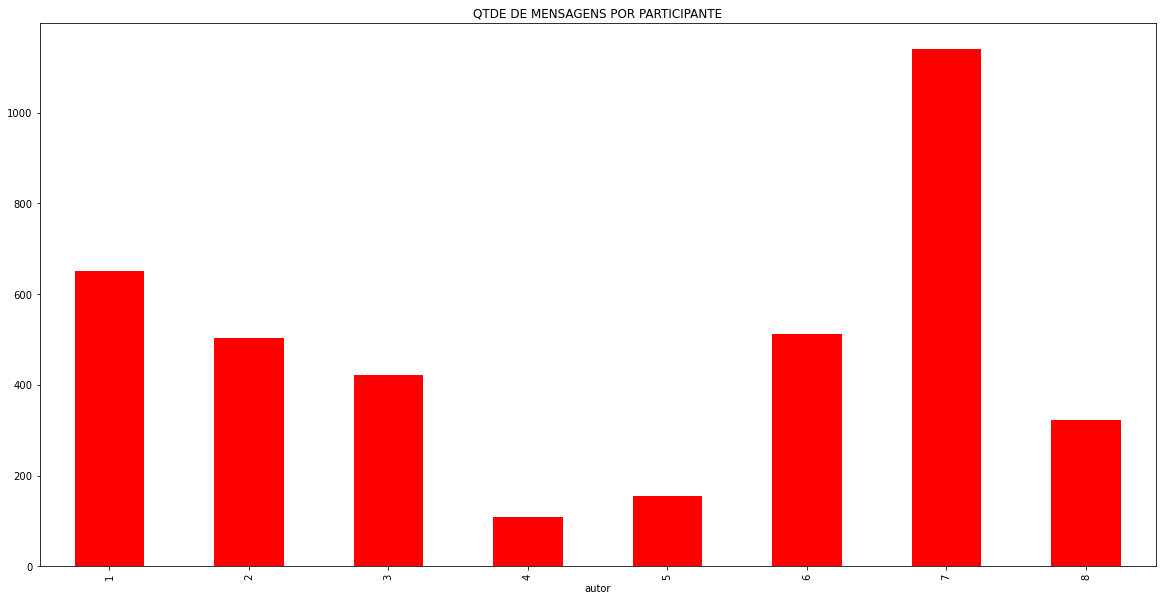

In [29]:
plt.title('QTDE DE MENSAGENS POR PARTICIPANTE')
participante_grupo = df.groupby('autor')['mensagem'].count().plot(kind='bar', figsize=(20,10), color='red')

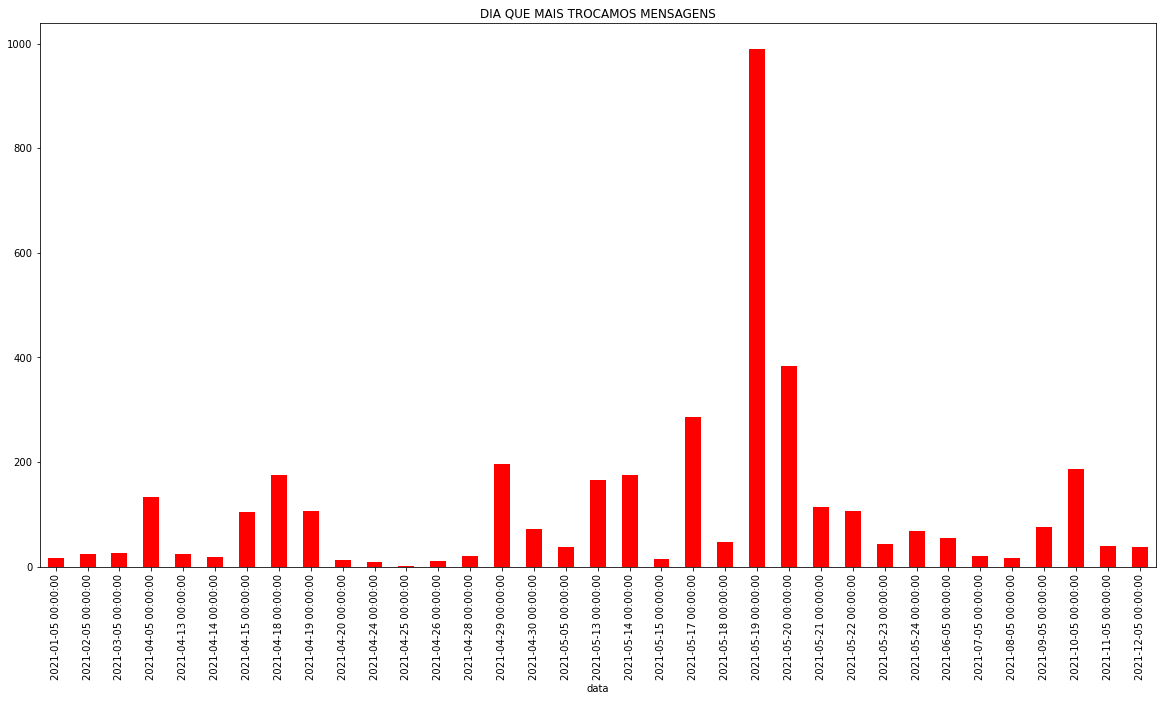

In [30]:
plt.title('DIA QUE MAIS TROCAMOS MENSAGENS')
date_grouped = df.groupby('data')['mensagem'].count().plot(kind='bar', figsize=(20,10), color='red')

In [31]:
hour_grouped_msg = (df.set_index ('hora') ['mensagem'] 
                          .groupby (level = 0) 
                          .value_counts () 
                          .groupby (level = 0) 
                          .sum () 
                          .reset_index (name = 'count'))
fig = px.bar (hour_grouped_msg, x = 'hora', y = 'count', 
                 labels = {'hour': '24 horas Período'}, 
                 height = 400) 
fig.update_traces (marker_color = '# EDCC8B', marker_line_color = '#D4A29C', 
                  marker_line_width = 1.5, opacity = 0.6) 
fig.update_layout (title_text = 'TOTAL DE MENSAGEM POR HORA') 
fig.show ()

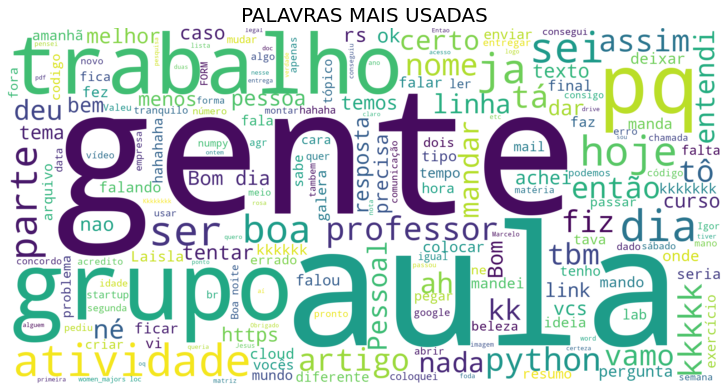

In [49]:

stopwords = set(STOPWORDS)
stopwords.update(["kkk", "kkkk", "aqui","mais", "acho", "vai", "vou","vc","mim", "ta", "q","mas","tem","sim","ai", "não","da", "meu", "uma","na","em", "você", "de", "ao", "os", "é", "já", "um", "e", "eu", "para", "ele", "que", "o", "se","só", "pra","a","à","agora","ainda","alguém","algum","alguma","algumas","alguns","ampla","amplas","amplo","amplos","ante","antes","ao","aos","após","aquela","aquelas","aquele","aqueles","aquilo","as","até","através","cada","coisa","coisas","com","como","contra","contudo","da","daquele","daqueles","das","de","dela","delas","dele","deles","depois","dessa","dessas","desse","desses","desta","destas","deste","deste","destes","deve","devem","devendo","dever","deverá","deverão","deveria","deveriam","devia","deviam","disse","disso","disto","dito","diz","dizem","do","dos","e","é","e'","ela","elas","ele","eles","em","enquanto","entre","era","essa","essas","esse","esses","esta","está","estamos","estão","estas","estava","estavam","estávamos","este","estes","estou","eu","fazendo","fazer","feita","feitas","feito","feitos","foi","for","foram","fosse","fossem","grande","grandes","há","isso","isto","já","la","la","lá","lhe","lhes","lo","mas","me","mesma","mesmas","mesmo","mesmos","meu","meus","minha","minhas","muita","muitas","muito","muitos","na","não","nas","nem","nenhum","nessa","nessas","nesta","nestas","ninguém","no","nos","nós","nossa","nossas","nosso","nossos","num","numa","nunca","o","os","ou","outra","outras","outro","outros","para","pela","pelas","pelo","pelos","pequena","pequenas","pequeno","pequenos","per","perante","pode","pôde","podendo","poder","poderia","poderiam","podia","podiam","pois","por","porém","porque","posso","pouca","poucas","pouco","poucos","primeiro","primeiros","própria","próprias","próprio","próprios","quais","qual","quando","quanto","quantos","que","quem","são","se","seja","sejam","sem","sempre","sendo","será","serão","seu","seus","si","sido","só","sob","sobre","sua","suas","talvez","também","tampouco","te","tem","tendo","tenha","ter","teu","teus","ti","tido","tinha","tinham","toda","todas","todavia","todo","todos","tu","tua","tuas","tudo","última","últimas","último","últimos","um","uma","umas","uns","vendo","ver","vez","vindo","vir","vos","vós"
 ])


# Gerar uma imagem wordcloud
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="WHITE", 
                      width=2000, height=1000).generate(text)

plt.figure(figsize=(12.8, 7.2))
plt.title("PALAVRAS MAIS USADAS", fontsize=20, color="black")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()